In [1]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.3MB 4.0MB/s 
     |████████████████████████████████| 901kB 44.1MB/s 
     |████████████████████████████████| 3.3MB 45.2MB/s 
     |████████████████████████████████| 1.2MB 4.2MB/s 


In [2]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

#from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel , Adafactor
from transformers import get_linear_schedule_with_warmup

In [3]:
from transformers import XLMForSequenceClassification , XLMRobertaTokenizerFast , XLMTokenizer , XLMRobertaForSequenceClassification

In [4]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [5]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

GPU in use: Tesla P100-PCIE-16GB


In [6]:
# extra preprocessing steps
# prepend CLS and append SEP, truncate, pad

#parameters for the dataset and dataloader
BATCH_SIZE = 32
max_sent_length=128

def preprocessing(df):
    sentences = df.sentence.values
    labels = np.array([ l for l in df.label.values])

    tokenizer =XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-large" , do_lower_case=True )
    
    encoded_sentences = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(
                            sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = max_sent_length
                    )
        
        encoded_sentences.append(encoded_sent)
    #encoded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, dtype="long", 
    #                        value=0, truncating="post", padding="post")
    
    return encoded_sentences, labels
    

In [7]:
df = pd.read_csv("/content/in_domain_train.tsv", 
                 delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

df_out = pd.read_csv("/content/out_of_domain_dev.tsv", 
                 delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

df_test = pd.read_csv("/content/in_domain_dev.tsv", 
                 delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [8]:
df = pd.concat([df, df_out ], ignore_index=True, sort=False)

In [9]:
train_encoded_sentences, train_labels = preprocessing(df)
test_encoded_sentences, test_labels = preprocessing(df_test)

In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset

class GrammerDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 
        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def attention_masks(self , encoded_sentences):
      # attention masks, 0 for padding, 1 for actual token
      attention_masks = []
      for sent in encoded_sentences:
          att_mask = [int(token_id != 1 ) for token_id in sent]
          attention_masks.append(att_mask)

      return attention_masks

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] 
        label_list = []
        mask_list = []

        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
        """
        
        # store the labels in label_list
        label_list = [datum[1] for datum in batch]
        # find the max sequence length from the batch
        max_batch_seq_len = max(len(datum[0]) for datum in batch)

        if max_batch_seq_len > self.max_sent_length:
          max_batch_seq_len = self.max_sent_length

        # pad each of the texts in batch
        for datum in batch:
          padded_vec = np.pad(np.array(datum[0]),
                              pad_width = ((0, max_batch_seq_len - len(datum[0]))),
                              mode = "constant", constant_values = 1)
          
          #generate the attention mask
          attention_mask = self.attention_masks( [padded_vec] )

          data_list.append(padded_vec)
          mask_list.append( attention_mask[0] )


        # convert to tensors
        data_list = torch.from_numpy(np.array(data_list))
        label_list = torch.LongTensor(label_list)
        mask_list = torch.from_numpy(  np.array( mask_list ) )

        return [data_list, mask_list , label_list]

In [11]:
train_dataset = GrammerDataset( train_encoded_sentences , train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)


valid_dataset = GrammerDataset( test_encoded_sentences , test_labels, train_dataset.max_sent_length)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

In [12]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)



model = XLMRobertaForSequenceClassification.from_pretrained( "xlm-roberta-large" , 
                             num_labels = 2 ,   
                             output_attentions = False, 
                             output_hidden_states = False,    )

model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 1e-5, 
                  eps = 1e-8, 
                  weight_decay = 0.01
                )

"""
optimizer = Adafactor( model.parameters(),
                      lr=1e-5,
                      eps=(1e-30, 1e-3),
                      clip_threshold=1.0,
                      decay_rate=-0.8,
                      beta1=None,
                      weight_decay=0.01,
                      relative_step=False,
                      scale_parameter=False,
                      warmup_init=False
)

"""
epochs = 20
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0 , # 10% * datasetSize/batchSize
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

In [13]:
model

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
     

In [14]:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

def compute_accuracy(preds, labels):
    p = np.argmax(preds, axis=1).flatten()
    l = labels.flatten()
    return np.sum(p==l)/len(l)

def run_train(epochs):

    losses = []

    for e in range(epochs):

        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        start_train_time = time.time()
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_loader):

            if step%10 == 0:
                elapsed = time.time()-start_train_time
                print(f'{step}/{len(train_loader)} --> Time elapsed {elapsed}')

            # input_data, input_masks, input_labels = batch
            input_data = batch[0].to(device)
            input_masks = batch[1].to(device)
            input_labels = batch[2].to(device)

            model.zero_grad()

            # forward propagation
            out = model(input_data,
                        token_type_ids = None, 
                        attention_mask = input_masks,
                        labels = input_labels)
            
            loss = out[0]
            total_loss = total_loss + loss.item()

            # backward propagation
            loss.backward()
            
            torch.nn.utils.clip_grad_norm(model.parameters(), 1)

            optimizer.step()
        
        epoch_loss = total_loss/len(train_loader)
        losses.append(epoch_loss)
        print(f"Training took {time.time()-start_train_time}")

        # Validation
        start_validation_time = time.time()
        model.eval()
        eval_loss, eval_acc = 0,0
        for step, batch in enumerate(valid_loader):
            batch = tuple(t.to(device) for t in batch)
            eval_data, eval_masks, eval_labels = batch
            with torch.no_grad():
                out = model(eval_data,
                            token_type_ids = None, 
                            attention_mask=eval_masks)
            logits = out[0]

            #  Uncomment for GPU execution
            logits = logits.detach().cpu().numpy()
            eval_labels = eval_labels.to('cpu').numpy()
            batch_acc = compute_accuracy(logits, eval_labels)

            # Uncomment for CPU execution
            # batch_acc = compute_accuracy(logits.numpy(), eval_labels.numpy())

            eval_acc += batch_acc
        print(f"Accuracy: {eval_acc/(step+1)}, Time elapsed: {time.time()-start_validation_time}")
    return losses
            

In [15]:
losses = run_train(epochs)

======== Epoch 1 / 20 ========
0/284 --> Time elapsed 0.03030109405517578


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


10/284 --> Time elapsed 4.548385143280029
20/284 --> Time elapsed 8.43670916557312
30/284 --> Time elapsed 12.567052364349365
40/284 --> Time elapsed 16.186969757080078
50/284 --> Time elapsed 20.17724633216858
60/284 --> Time elapsed 24.175666570663452
70/284 --> Time elapsed 28.119767427444458
80/284 --> Time elapsed 31.978269815444946
90/284 --> Time elapsed 35.9216034412384
100/284 --> Time elapsed 39.55854940414429
110/284 --> Time elapsed 43.438857078552246
120/284 --> Time elapsed 47.393128871917725
130/284 --> Time elapsed 51.0744514465332
140/284 --> Time elapsed 54.93984866142273
150/284 --> Time elapsed 58.45712184906006
160/284 --> Time elapsed 62.38796854019165
170/284 --> Time elapsed 66.03950476646423
180/284 --> Time elapsed 69.81658816337585
190/284 --> Time elapsed 73.38852214813232
200/284 --> Time elapsed 77.1658673286438
210/284 --> Time elapsed 81.23037600517273
220/284 --> Time elapsed 85.20038890838623
230/284 --> Time elapsed 89.08843731880188
240/284 --> Time 

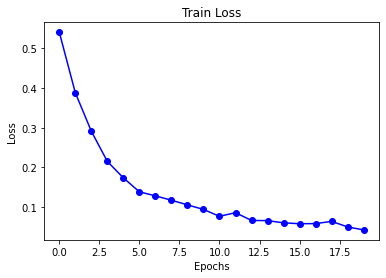

In [16]:
# plot losses
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns 

plt.plot(losses, 'b-o')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [17]:
import os 

output_dir = './model_save'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

In [21]:
def run_test(df_test):

    test_batch_size = 16

    test_encoded_sentences, test_labels = preprocessing(df_test)

    test_dataset = GrammerDataset( test_encoded_sentences , test_labels, max_sent_length)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size= test_batch_size  ,
                                              collate_fn=train_dataset.spam_collate_func,
                                              shuffle=False)
    sentences = df_test.sentence.values

    model.eval()
    eval_loss, eval_acc = 0,0

    for step, batch in enumerate(test_loader):

        sentence_batch = sentences[  step*test_batch_size  : (step + 1)*test_batch_size ]

        batch = tuple(t.to(device) for t in batch)
        eval_data, eval_masks, eval_labels = batch
        with torch.no_grad():
            out = model(eval_data,
                        token_type_ids = None,
                        attention_mask=eval_masks)
        logits = out[0]
        logits = logits.detach().cpu().numpy()
        eval_labels = eval_labels.to('cpu').numpy()
        batch_acc = compute_accuracy(logits, eval_labels)
        eval_acc += batch_acc

        preds = np.argmax( logits , axis=1).flatten()

        for i_index in range( len(preds) ):

          i_sentence = sentence_batch[i_index]
          i_target = eval_labels[ i_index ]
          i_pred = preds[ i_index ]

          print( "Sentence : {}  Target Label : {}  Prediction Label : {}  \n".format(  i_sentence , i_target , i_pred  ) )
        
        print("# of sentences: ", len(preds))

    print(f"Final Mode Accuracy: {eval_acc/(step+1)}")

In [22]:
print("Evaluating on english \n")
df_test = pd.read_csv("/content/in_domain_dev.tsv", 
                 delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
run_test(df_test)

Evaluating on english 

Sentence : The sailors rode the breeze clear of the rocks.  Target Label : 1  Prediction Label : 0  

Sentence : The weights made the rope stretch over the pulley.  Target Label : 1  Prediction Label : 1  

Sentence : The mechanical doll wriggled itself loose.  Target Label : 1  Prediction Label : 1  

Sentence : If you had eaten more, you would want less.  Target Label : 1  Prediction Label : 1  

Sentence : As you eat the most, you want the least.  Target Label : 0  Prediction Label : 1  

Sentence : The more you would want, the less you would eat.  Target Label : 0  Prediction Label : 1  

Sentence : I demand that the more John eat, the more he pays.  Target Label : 0  Prediction Label : 0  

Sentence : Mary listens to the Grateful Dead, she gets depressed.  Target Label : 1  Prediction Label : 1  

Sentence : The angrier Mary got, the more she looked at pictures.  Target Label : 1  Prediction Label : 1  

Sentence : The higher the stakes, the lower his expec

In [23]:
print("Evaluating on french \n")
df_test = pd.read_csv("/content/french_data.csv", header=None, names=['label', 'sentence'] , skiprows=1)
run_test(df_test)

Evaluating on french 

Sentence : Emma mange une pomme.   Target Label : 1  Prediction Label : 1  

Sentence : J'ai visité la Tour Eiffel le dimanche dernier.  Target Label : 1  Prediction Label : 1  

Sentence : Le livre a été lu par ma sœur.  Target Label : 1  Prediction Label : 1  

Sentence : Il ne faut pas faire des bêtises.  Target Label : 1  Prediction Label : 1  

Sentence : Maman ma dit de ne pas regarder trop de télévision.  Target Label : 1  Prediction Label : 1  

Sentence : Mon ami Pierre aime les tomates, mais il n'aime pas les avocats.  Target Label : 1  Prediction Label : 1  

Sentence : Je voudrais aller au Japon pendants les vacances.   Target Label : 1  Prediction Label : 1  

Sentence : Sais-tu où est mon chien?   Target Label : 1  Prediction Label : 1  

Sentence : Élise ma raconté qu'elle avait passé ses vacances en Cannes.   Target Label : 1  Prediction Label : 1  

Sentence : Henri ne sais pas pourquoi sa copine est en colère.  Target Label : 1  Prediction Label

In [24]:
print("Evaluating on chinese \n")
df_test = pd.read_csv("/content/chinese_data.csv",  header=None, names=['label', 'sentence'] , skiprows= 1 )
run_test(df_test)

Evaluating on chinese 

Sentence : 年夜饭常常有鱼，但是在北部，人们也喜欢吃饺子。在南部，人们喜欢吃年糕。  Target Label : 1  Prediction Label : 1  

Sentence : 去年的黄金周，我跟我的朋友们一起去南京。我的最好的朋友让我参加旅行，因为我们有三天的周末。  Target Label : 1  Prediction Label : 1  

Sentence : 介绍一下云南省和云南省的几个旅游景点。  Target Label : 1  Prediction Label : 1  

Sentence : 这个城市吸引了很多人，特别是年轻的人，因为城市有教育和工作机会，外国客人和很多好玩的事情。  Target Label : 1  Prediction Label : 1  

Sentence : 要是你去上海，一定会看见到处都有建筑工人在修马路，大桥和高楼。  Target Label : 1  Prediction Label : 1  

Sentence : 我们的时间在南京很短，但是我想又去为了做很多活动。  Target Label : 1  Prediction Label : 1  

Sentence : 我没参加过旅游团，所以我不知道。  Target Label : 1  Prediction Label : 1  

Sentence : 我觉得秦朝给我留下的印象很深，因为秦始皇当中国第一皇帝。  Target Label : 1  Prediction Label : 1  

Sentence : 差不多4点30早上 我们去火车站。  Target Label : 1  Prediction Label : 1  

Sentence : 我们的课都完了以后，为了准备旅行，我们回宿舍。  Target Label : 1  Prediction Label : 1  

Sentence : 我爱你。  Target Label : 1  Prediction Label : 1  

Sentence : 我很累。  Target Label : 1  Prediction Label : 1  

Sentence : 今天我有一个考试。  Ta